In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Loading the data

In [2]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
prdlabel = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
prdlabel = prdtype.loc[prdlabel['prdtypecode'], 'prdtypedesignation']
prdlabel = prdlabel.reset_index()

In [2]:
folder_path = '../data/clean/'
data_train = pd.read_csv(os.path.join(folder_path, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(folder_path, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0)

In [3]:
data.head()

,Unnamed: 0,designation,description,productid,imageid,language,designation_translated,description_translated,prdtypecode,prdtypedesignation,prdtypefull,prdtypeindex,testset
0,0,Porte Bébé Violet Et Rouge Trois-En-Un Mère Mu...,Porte bébé Violet et rouge Trois-en-un mère mu...,3050424970,1187504001,fr,Porte Bébé Violet Et Rouge Trois-En-Un Mère Mu...,Porte bébé Violet et rouge Trois-en-un mère mu...,1320,Puériculture,1320 - Puériculture,9,False
1,1,Jesus - Cahiers Du Libre Avenir,Prêtre autrement.,131641431,885888766,fr,Jesus - Cahiers Du Libre Avenir,Prêtre autrement.,10,Livres occasion,10 - Livres occasion,0,False
2,2,Chambre Paillasson En Forme De Coeur Tapis Flu...,Chambre Paillasson en forme de coeur Tapis Tap...,4197486437,1313030973,fr,Chambre Paillasson En Forme De Coeur Tapis Flu...,Chambre Paillasson en forme de coeur Tapis Tap...,1560,Mobilier,1560 - Mobilier,10,False
3,3,2pcs En Alliage D'aluminium Portail Du Carter ...,2pcs en alliage d'aluminium Portail du carter ...,3929174950,1265009801,fr,2pcs En Alliage D'aluminium Portail Du Carter ...,2pcs en alliage d'aluminium Portail du carter ...,1280,Jouets enfants,1280 - Jouets enfants,4,False
4,4,Harnais Chien Arnais Noir Anti Traction Gilet ...,La description: Fait de matériau souple doux ...,4183293159,1313455838,fr,Harnais Chien Arnais Noir Anti Traction Gilet ...,La description: Fait de matériau souple doux ...,2220,Animalerie,2220 - Animalerie,14,False


## Identify duplicates with different product type code

In [3]:
#identify duplicates with same designation and description but different product type code
data_duplicated = data.join(prdlabel.reset_index())
data_duplicated['description'] = data_duplicated['description'].fillna('')
data_duplicated = data_duplicated[data_duplicated.duplicated(['designation', 'description'], keep=False)]
data_duplicated = data_duplicated.groupby(['description', 'designation']).filter(lambda x: x['prdtypecode'].nunique() > 1)
idx_duplicates = data_duplicated.index

In [ ]:
#Remove those duplicates
data = data.drop(index=idx_duplicates)
prdlabel = prdlabel.drop(index=idx_duplicates)

## Tokenize translated text

In [4]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
merged_txt = data[colnames].apply(lambda row: ' '.join(s for s in row if isinstance(s, str)), axis=1)
data['tokens'] = merged_txt.str.lower().apply(lambda x: word_tokenize(x, language='french'))

## Remove stopwords and punctuation from tokens

In [23]:
def remove_wordsubset(words, wordsubset):
    #remove words in wordsubset
    words_filtered = [word for word in words if word not in wordsubset]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [ ]:
#Removing stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, stop_words))

In [26]:
#Removing puntuation
punctuations = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, punctuations))

In [109]:
#Removing duplicated tokens
data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

In [5]:
#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Further cleaning with Regex?

In [ ]:
#import re

#remove words shorter than 4 characters
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b\w{1,2}\b(?!°)", ' ', x))

#remove numbers
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"[0-9]+", ' ', x))

#remove any word that has no vowel
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?![^aeiouyáéíóúàèìòùâêîôûäëïöü])[^\s]+\b", ' ', x))

#removing extra spaces
#data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x.split()))

## Function to plot results

In [6]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Creating train and test sets

In [9]:
from sklearn.model_selection import train_test_split

target = data['prdtypedesignation']
#Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], target, test_size=0.2, random_state=123, stratify=target)

In [7]:
X_train = data.loc[~data['testset'], 'tokens']
X_test = data.loc[data['testset'], 'tokens']
y_train = data.loc[~data['testset'],'prdtypeindex']
y_test = data.loc[data['testset'],'prdtypeindex']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67932,), (16984,), (67932,), (16984,))

In [91]:
target.head()

0       Puériculture
1    Livres occasion
2           Mobilier
3     Jouets enfants
4         Animalerie
Name: prdtypedesignation, dtype: object

## Label encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

target = data['prdtypedesignation']

#Encoding classes as integers
encoder = LabelEncoder()
y_class = encoder.fit_transform(target)

## BERT Tokenization (camembert-base)

In [4]:
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer, CamembertModel, CamembertTokenizer

model_name = "camembert-base" #"flaubert/flaubert_base_uncased" #
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_bert = TFAutoModel.from_pretrained(model_name)


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-06 08:36:15.458121: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 08:36:15.458363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 08:36:15.509604: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 08:36:15.509670: I exte

In [67]:
max_length = 256 #512 #

X_train = tokenizer(data.loc[~data['testset'],'tokens'].tolist(), padding="max_length", truncation=True, max_length=max_length, return_tensors="tf")
X_test = tokenizer(data.loc[data['testset'],'tokens'].tolist(), padding="max_length", truncation=True, max_length=max_length, return_tensors="tf")

X_train['token_type_ids'] = tf.zeros_like(X_train['input_ids'], dtype=tf.int32)
X_test['token_type_ids'] = tf.zeros_like(X_test['input_ids'], dtype=tf.int32)

y_train = y_class[~data['testset']]
y_test = y_class[data['testset']]

In [62]:
X_train

{'input_ids': <tf.Tensor: shape=(67932, 256), dtype=int32, numpy=
array([[   5,  438, 1849, ...,    1,    1,    1],
       [   5,   50, 8452, ...,    1,    1,    1],
       [   5,  608, 2994, ...,    1,    1,    1],
       ...,
       [   5, 8111,  808, ...,    1,    1,    1],
       [   5,   24,   21, ...,    1,    1,    1],
       [   5,  102,  518, ...,    1,    1,    1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(67932, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [33]:
from sklearn.model_selection import train_test_split

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 32
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [5]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

num_class = len(np.unique(y_class))
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(max_length,), dtype='int32', name='attention_mask')

transformer_layer = model_bert({'input_ids': input_ids, 'attention_mask': attention_mask})

x = transformer_layer[0][:, 0, :]

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(num_class, activation='softmax')(x)

# Construct the final model
model = Model(inputs={'input_ids': input_ids, 'attention_mask': attention_mask}, outputs=output)

lr = 5e-5
lr_schedule = ExponentialDecay(initial_learning_rate=lr, decay_steps=2000, decay_rate=0.8)
optimizer = Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['attention_mask[0][0]',      
 mbertModel)                 ngAndCrossAttentions(last_   52         'input_ids[0][0]']           
                             hidden_state=(None, 256, 7                                       

In [ ]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

In [29]:
import tensorflow as tf
len(tf.config.experimental.list_physical_devices('GPU'))


2

In [96]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [22]:
#max_length = 256 with batch_size=32 seems to be the limit memory wise. Could try 512 and 16 if sequence length needs to be increased
# history = model.fit([X_train, attention_masks_train], y_train, epochs=5, batch_size=32, validation_data=([X_test, attention_masks_test], y_test)) #class_weight
history = model.fit(train_data, epochs=5, validation_data=test_data)#, class_weight=class_weights)


Epoch 1/5
2123/2123 [==============================] - 1538s 708ms/step - loss: 0.8758 - accuracy: 0.7712 - val_loss: 0.5171 - val_accuracy: 0.8468
Epoch 2/5
2123/2123 [==============================] - 1493s 703ms/step - loss: 0.4634 - accuracy: 0.8639 - val_loss: 0.4604 - val_accuracy: 0.8633
Epoch 3/5
2123/2123 [==============================] - 1488s 701ms/step - loss: 0.3486 - accuracy: 0.8955 - val_loss: 0.4498 - val_accuracy: 0.8722
Epoch 4/5
2123/2123 [==============================] - 1488s 701ms/step - loss: 0.2690 - accuracy: 0.9185 - val_loss: 0.4464 - val_accuracy: 0.8790
Epoch 5/5
2123/2123 [==============================] - 1483s 699ms/step - loss: 0.2197 - accuracy: 0.9351 - val_loss: 0.4874 - val_accuracy: 0.8760


In [101]:
save_path='../models/camemBERT_base_256_32'
model.save(save_path)
model.save_weights(save_path+'/tf_model.h5')

INFO:tensorflow:Assets written to: ../models/camemBERT_base_256_32/assets


INFO:tensorflow:Assets written to: ../models/camemBERT_base_256_32/assets


In [102]:
model2 = tf.keras.models.load_model(save_path)

ValueError: The two structures don't have the same nested structure.

First structure: type=tuple str=(({'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, None, None, None, None, None, None, None, None, None, None, None, None, True), {})

Second structure: type=tuple str=(({'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int32, name='input_ids_attention_mask'), 'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name='input_ids_input_ids')}, None, None, None, None, None, None, None, None, None, None, None, None, True), {})

More specifically: The two dictionaries don't have the same set of keys. First structure has keys type=list str=['attention_mask', 'input_ids', 'token_type_ids'], while second structure has keys type=list str=['attention_mask', 'input_ids']
Entire first structure:
(({'attention_mask': ., 'input_ids': ., 'token_type_ids': .}, ., ., ., ., ., ., ., ., ., ., ., ., .), {})
Entire second structure:
(({'attention_mask': ., 'input_ids': .}, ., ., ., ., ., ., ., ., ., ., ., ., .), {})

In [77]:


if not os.path.exists(save_path):
    os.makedirs(save_path)
    
model.save_weights(save_path + '/weights.h5')
tokenizer.save_pretrained(save_path + '/tokenizer')

('../models/camemBERT_base_128_32/tokenizer/tokenizer_config.json',
 '../models/camemBERT_base_128_32/tokenizer/special_tokens_map.json',
 '../models/camemBERT_base_128_32/tokenizer/tokenizer.json')

In [75]:
model.load_weights(filepath=save_path + '/weights.h5')

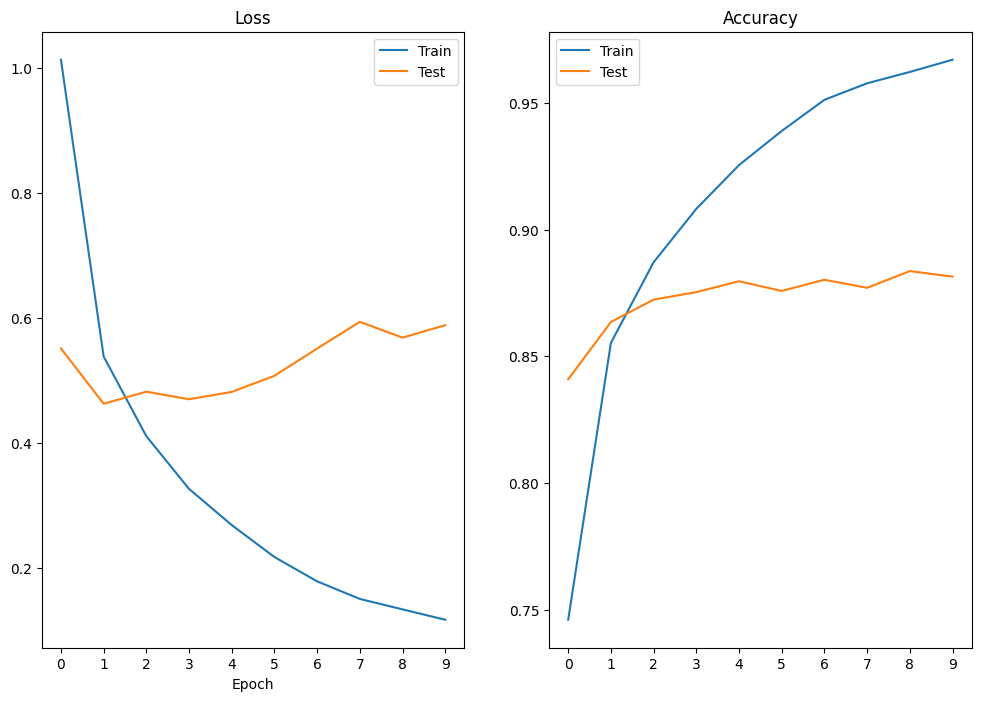

In [108]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Test')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(history.epoch)
axs[0].legend()
axs[0].set_title('Loss')

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Test')
axs[1].set_xticks(history.epoch)
axs[1].legend()
axs[1].set_title('Accuracy')

plt.show()

531/531 [==============================] - 150s 273ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       333
           1       0.87      0.92      0.89       173
           2       0.97      0.96      0.96       828
           3       0.96      0.98      0.97       181
           4       0.90      0.93      0.91       161
           5       0.84      0.53      0.65       161
           6       0.77      0.86      0.81       533
           7       0.96      0.94      0.95      1063
           8       0.82      0.64      0.72       433
           9       0.98      0.99      0.98      1009
          10       0.79      0.79      0.79       497
          11       0.86      0.80      0.83       273
          12       0.97      0.99      0.98       177
          13       0.83      0.76      0.80       959
          14       0.92      0.95      0.94       828
          15       0.90      0.82      0.85       964
          16       0.7

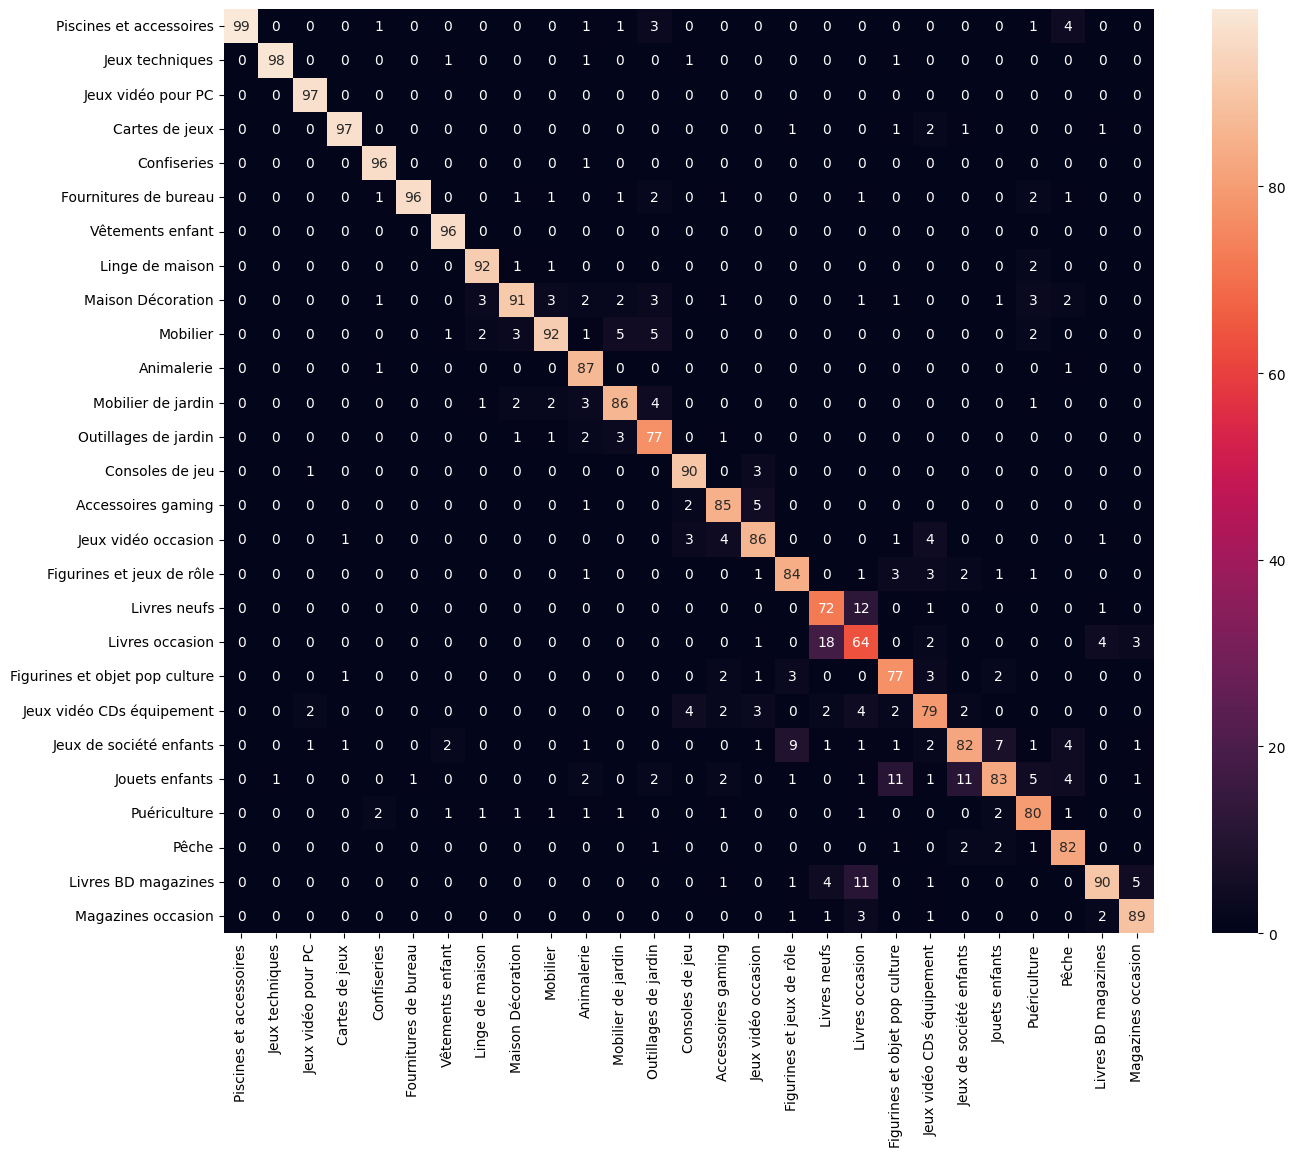

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [109]:
test_pred = model.predict([X_test, attention_masks_test])
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(y_test, test_pred_class, index=encoder.classes_)

In [110]:
from sklearn.metrics import f1_score

f1_score(y_test, test_pred_class, average='weighted')

0.8812595175925467

In [5]:
import os
os.getcwd()

'/mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/notebook'

In [6]:
import sys
sys.path.append('../')

from src.text.classifiers import build_model

/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-05 12:49:23.750677: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 12:49:23.873053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 12:49:23.873131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 12:49:2

In [8]:
import sys
sys.path.append('../')

from src.text.classifiers import TFbertClassifier

test_model = TFbertClassifier(base_name='camembert-base', from_trained = None, max_length=256, num_class=27, drop_rate=0.2)

/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['transformers.py', '__init__.py', '__pycache__']


2024-03-05 16:30:08.600689: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 16:30:08.601035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 16:30:08.658852: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 16:30:08.658924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 16:30:08.658958: I external/local_xla/xla/stream_executor

In [9]:
test_model.fit(X_train[:1000], y_train[:1000])

2024-03-05 16:14:42.316730: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2024-03-05 16:15:11.840943: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f72f14a3390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 16:15:11.840992: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-05 16:15:11.841000: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-05 16:15:11.846469: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-05 16:15:12.543523: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709651712.681351  391249 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 66s 627ms/step - loss: 3.0103 - accuracy: 0.2090


TFbertClassifier()

In [10]:
y_pred = test_model.predict(X_train[:100])

4/4 [==============================] - 4s 229ms/step


In [9]:
y_probs = test_model.predict_proba(X_train[:100])

2024-03-05 16:30:28.624926: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


4/4 [==============================] - 9s 219ms/step


In [8]:
test_model.save(dirpath='../models/trained_models', name='test')

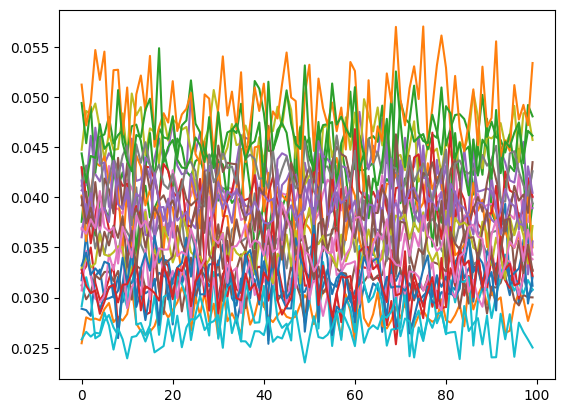

In [11]:
plt.plot(y_probs[:100], label='predictions')
# plt.plot(y_test[:20], label='real')
plt.show()

In [113]:
save_path='../models/camemBERT_base_256_32'
if not os.path.exists(save_path):
    os.makedirs(save_path)
test_model.save_weights(save_path+'/weights.h5')

In [95]:
test_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 tf_camembert_model_12 (TFC  TFBaseModelOutputWithPooli   1106219   ['attention_mask[0][0]',      
 amembertModel)              ngAndCrossAttentions(last_   52         'input_ids[0][0]']           
                             hidden_state=(None, 256, 7                                    

## Inspect prediction errors

In [150]:
bad = data.loc[X_test.index[test_pred_class != y_test_class]].reset_index()
bad_pred = pd.DataFrame({'predicted': encoder.inverse_transform(test_pred_class[test_pred_class != y_test_class])})
bad_true = pd.DataFrame({'real': encoder.inverse_transform(y_test_class[test_pred_class != y_test_class])})
bad = pd.concat([bad, bad_pred, bad_true], axis=1)
bad = bad[['designation', 'description', 'tokens', 'predicted', 'real']]